# 畳み込みニューラルネットワーク (CNN)

## 今日の目標
カラー画像の分類に挑戦してみよう

## 目次

- Section1 畳み込みニューラルネットワークとは
  - 1.1 CNNの構成
  - 1.2 畳み込み層 (Convolution Layer)
  - 1.3 プーリング層 (Pooling Layer)
  - 1.4 全結合層 (Dense Layer)
  - 1.5 正規化層 (Normalization Layer)
- Section2 汎化性能を上げる
  - 2.1 大規模データセットの利用
  - 2.2 データ拡張
  - 2.3 前処理
  - 2.4 バッチ正規化
  - 2.5 ドロップアウト
  - 2.6 正則化
  - 2.7 初期化
- Section3 Pytorchでの実装
- Section4 有名なCNN
  - 4.1 LeNet
  - 4.2 AlexNet
  - 4.3 

In [1]:
# # Googleドライブのマウント（Colab使いのみ）

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/dlc/week3

In [2]:
# 図表が使えるようにする

import matplotlib.pyplot as plt
%matplotlib inline

## Section1 CNNとは

### 1.1 CNNの構成

**Convolutional Neural Network (CNN)** は画像認識、音声認識、自然言語処理など、幅広くタスクにおいて使用されているニューラルネットワークの一種です。中でも、画像認識で高い精度を上げたモデルにはCNNをベースに設計されたものが多くあります。

CNNは **畳み込み層 (Convolution layer)** ・ **プーリング層 (Pooling layer)** 呼ばれる層を組み合わせて構築していきます。(2種類の層で構築可能ですが、出力に近い層は **全結合層 (Dense layer)** を組み合わせることがほとんどです。)


<img src="figures/cnn.png" width="60%">

出典：https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html

### 1.2 畳み込み層 (Convolution Layer)


#### 1.2.1 畳み込みの考え方

畳み込みは入力のある領域とフィルタの内積を計算することによってフィルタとの類似度のようなものを計算することです。フィルタの数を増やすと多くの特徴を、フィルタのサイズを大きくすると広い範囲の特徴を、小さくすると狭い範囲の特徴を獲得できます。

畳み込みによって得られるものを **特徴マップ (feature map)** と呼ぶことがあります。

<img src="figures/conv.gif" width="500">

出典：http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif

In [3]:
from PIL import Image
import numpy as np
import torch
import torchvision

def tensor2plot(ts_input, ts_kernel, ts_output):
    fig = plt.figure()
    ax0 = plt.subplot2grid((1, 11), (0, 0), colspan=4)
    ax1 = plt.subplot2grid((1, 11), (0, 5), colspan=1)
    ax2 = plt.subplot2grid((1, 11), (0, 7), colspan=4)
    ax0.set_title('x'.join([str(_) for _ in ts_input[0][0].size()]))
    ax0.imshow(ts_input[0][0], cmap='gray')
    ax1.set_title('x'.join([str(_) for _ in ts_kernel[0][0].size()]))
    ax1.imshow(ts_kernel[0][0], cmap='gray')
    ax2.set_title('x'.join([str(_) for _ in ts_output[0][0].size()]))
    ax2.imshow(ts_output[0][0].detach().numpy(), cmap='gray')

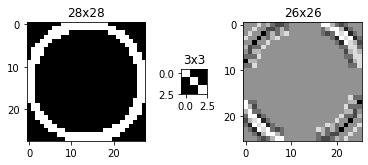

In [4]:
img = Image.open('./figures/example2.png')
trans = torchvision.transforms.ToTensor()
input_image = trans(img.convert('L')).unsqueeze(0)

kernel = torch.tensor(np.array(
    [[1, -0.5, -0.5]
    ,[-0.5, 1, -0.5]
    ,[-0.5, -0.5, 1]]
).astype('float32')).reshape(1, 1, 3, 3)

Conv = torch.nn.Conv2d(
    in_channels=1, 
    out_channels=1, 
    kernel_size=(3, 3), 
    bias=False
)
Conv.weight.data = kernel
output_map = Conv(input_image)

tensor2plot(input_image, Conv.weight.data, output_map)

#### 1.2.2 パディング

入力に対してそのまま畳み込むと出力される特徴マップのサイズは小さくなります。これを防ぐために行われる、入力の端に0などの値をくっつける処理のことを **パディング (padding)** と言います。 

<img src="figures/padding.png" width="60%">

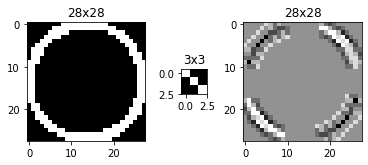

In [5]:
img = Image.open('./figures/example2.png')
trans = torchvision.transforms.ToTensor()
input_image = trans(img.convert('L')).unsqueeze(0)

kernel = torch.tensor(np.array(
    [[1, -0.5, -0.5]
    ,[-0.5, 1, -0.5]
    ,[-0.5, -0.5, 1]]
).astype('float32')).reshape(1, 1, 3, 3)

Conv = torch.nn.Conv2d(
    in_channels=1, 
    out_channels=1, 
    kernel_size=(3, 3), 
    padding=1,
    padding_mode='zeros',
    bias=False
)
Conv.weight.data = kernel
output_map = Conv(input_image)

tensor2plot(input_image, Conv.weight.data, output_map)

### 1.2.3 ストライド

フィルタを畳みこむ間隔のことを **ストライド (stride)** と言います。

<img src="figures/stride.gif" width="60%">

入力サイズを $I_w, I_h$、フィルタサイズを $k_w, k_h$ 、パディングを $p$、ストライドを $s$ とすると、出力サイズ $O_w, O_h$ は

$$ O_w = \frac{I_w + 2p - k_w}{s} + 1 $$
$$ O_h = \frac{I_h + 2p - k_h}{s} + 1 $$

となります。

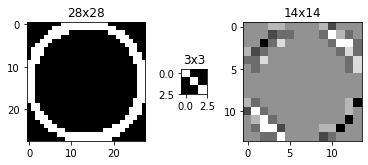

In [6]:
img = Image.open('./figures/example2.png')
trans = torchvision.transforms.ToTensor()
input_image = trans(img.convert('L')).unsqueeze(0)

kernel = torch.tensor(np.array(
    [[1, -0.5, -0.5]
    ,[-0.5, 1, -0.5]
    ,[-0.5, -0.5, 1]]
).astype('float32')).reshape(1, 1, 3, 3)

Conv = torch.nn.Conv2d(
    in_channels=1, 
    out_channels=1, 
    kernel_size=(3, 3), 
    padding=1,
    stride=2,
    bias=False
)
Conv.weight.data = kernel
output_map = Conv(input_image)

tensor2plot(input_image, Conv.weight.data, output_map)

#### 1.2.4 畳み込み層の特徴

畳み込み層はMLPのような全結合層だけで構成されたモデルと比較すると、
- 局所結合
- 重み共有

という特徴があり、パラメータ数が少なくなるというメリットがあります。

そのため2次元の画像のように、近い画素同士の関係性が強く、離れた画素同士の関係性が低いと考えられるデータに最適です。

<img src="figures/sharing.png" width="60%">

### 1.3 プーリング層 (Pooling Layer)

#### 1.3.1 プーリングの考え方

小さな領域に対して統計量 (最大値、平均値等) を取ることで、特徴をなるべく失わずにデータ量を圧縮＆位置のズレに対して頑強な特徴抽出を行います。

主に、最大値プーリング (max pooling) と平均値プーリング (average pooling) が用いられます。

<img src="figures/max_pooling.png" width="60%">

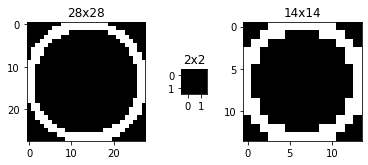

In [7]:
img = Image.open('./figures/example2.png')
trans = torchvision.transforms.ToTensor()
input_image = trans(img.convert('L')).unsqueeze(0)

Pool = torch.nn.MaxPool2d(
    kernel_size=(2, 2), 
    padding=0,
    stride=None,
)
output_map = Pool(input_image)

tensor2plot(input_image, trans(np.zeros((2, 2))).unsqueeze(0), output_map)

### 1.4 全結合層 (Dense Layer)

全結合層は、多層パーセプトロンと同様に重み付き結合を計算し、活性化関数によって値を求めます。局所的な特徴を捉える畳み込み層、プーリング層と違って広域的な特徴を捉えることに長けていますが、位置情報を失ってしまうためネットワークの最後で使われます。

### 1.5 正規化層 (Normalization Layer)

数多くの手法が提案されましたが、ほとんど効果がないと示されたため、新たに使われることはめったにありません。少し古いモデルに導入されているケースがあります。